In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
df = pd.read_csv("Apple_Historical_StockPrice2.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


df = df.set_index(['Date'])
df.sort_index(inplace=True)
df = df.groupby(pd.Grouper(freq='W')).mean()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-03,26.902000,27.215000,26.780999,27.070500,25.178509,118372000.0
2016-04-10,27.451000,27.704500,27.259000,27.454500,25.535671,116578080.0
2016-04-17,27.642000,27.907000,27.467501,27.672500,25.738435,129848000.0
2016-04-24,26.767500,26.922500,26.468500,26.658500,24.795308,151242400.0
2016-05-01,24.825500,25.113000,24.543000,24.791000,23.058328,279539280.0
...,...,...,...,...,...,...
2021-02-28,124.795999,126.659999,121.592000,123.892000,123.892000,137149760.0
2021-03-07,123.940001,125.580000,121.166000,123.303999,123.303999,132261940.0
2021-03-14,120.918001,121.921999,118.974001,120.084000,120.084000,117111120.0


<AxesSubplot:title={'center':'Residual'}, xlabel='Date'>

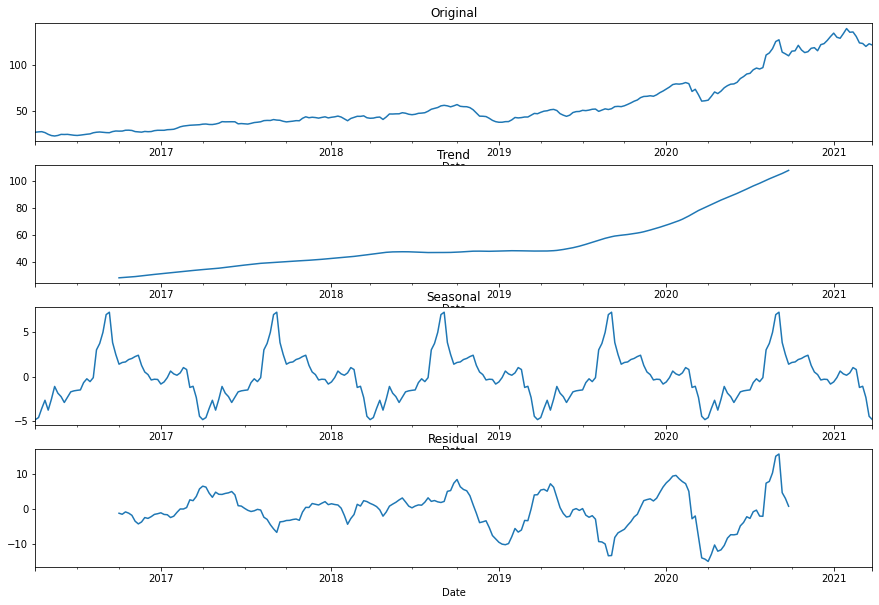

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))

result = seasonal_decompose(df['Close'], model='additive')

axs[0].set_title('Original')
axs[1].set_title('Trend')
axs[2].set_title('Seasonal')
axs[3].set_title('Residual')

result.observed.plot(ax=axs[0])
result.trend.plot(ax=axs[1])
result.seasonal.plot(ax=axs[2])
result.resid.plot(ax=axs[3])

<AxesSubplot:xlabel='Date'>

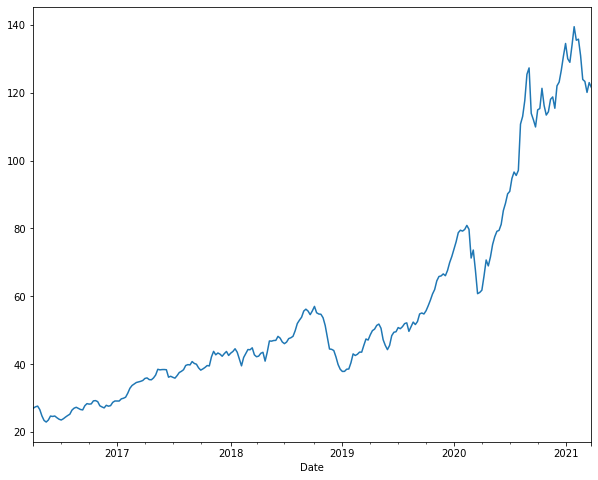

In [6]:
df.Close.plot(figsize=(10,8))

<AxesSubplot:xlabel='Date'>

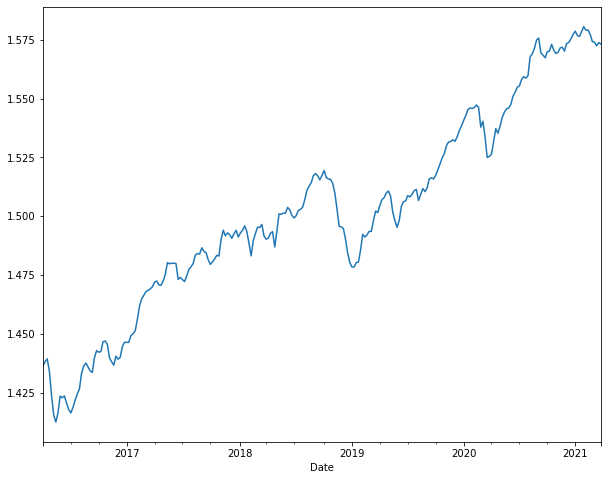

In [7]:
from scipy.special import boxcox, inv_boxcox
figure(figsize=(10,8))
boxcox(df['Close'], -0.6).plot(figsize=(10,8))

In [8]:
bx = -0.6

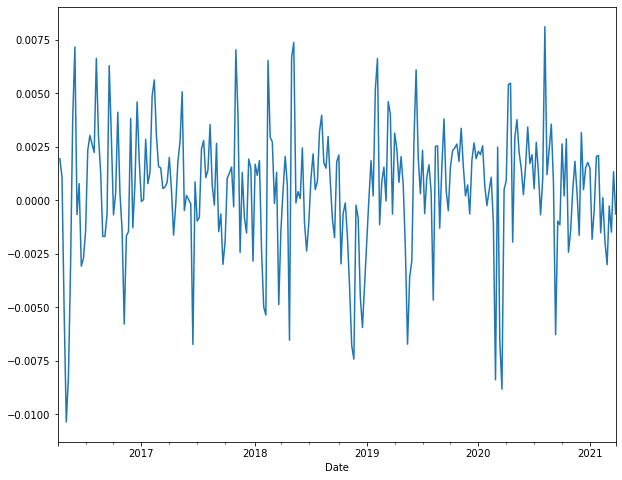

In [9]:
df['CloseProc'] = boxcox(df['Close'], bx).diff()
df['CloseProc'].plot(figsize=(10,8))
df = df.fillna(method='backfill')

In [10]:
import statsmodels.api as sm

test = sm.tsa.adfuller(df['CloseProc'])
print("adf: ", test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
    print('ряд не стационарен')
else:
    print('ряд стационарен')

adf:  -11.04867083513876
p-value:  5.145622050489607e-20
Critical values:  {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}
ряд стационарен


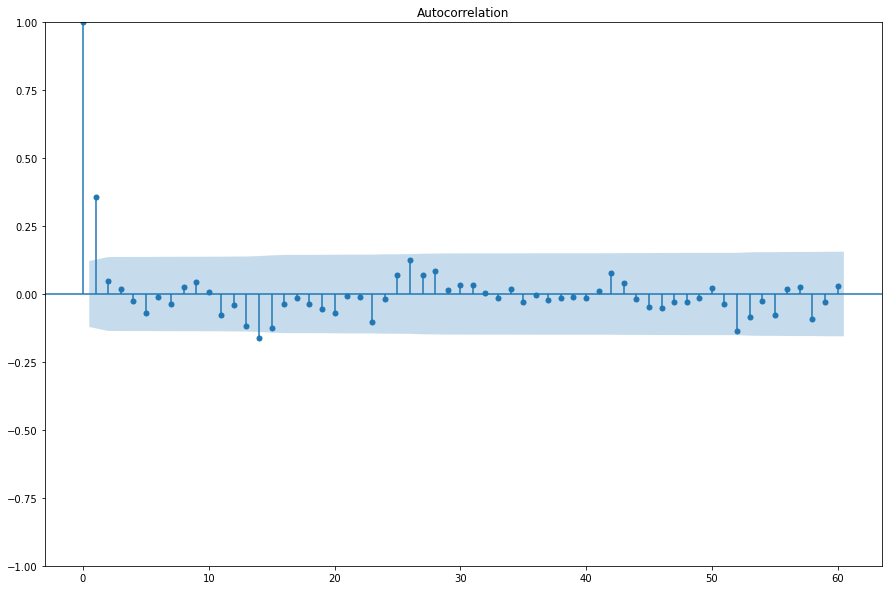

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(15, 10))
ax = plt.subplot()
plot_acf(df['CloseProc'], lags=60, ax=ax)
plt.show()

# SARIMA

In [12]:
%pip install pmdarima --user
from pmdarima.arima import auto_arima

Note: you may need to restart the kernel to use updated packages.


In [13]:
num = int(len(df) * 0.805)
len(df['CloseProc'][:num])

210

In [48]:
model = auto_arima(df['CloseProc'][:num], start_p=0, start_q=0, test='adf', max_p=2, max_q=1, m=52,
           start_P=0, start_Q = 0, max_P = 1, max_Q = 1, d=0,D=1, seasonal=True, error_action ='ignore', supress_warnings=True)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  210
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood                 657.014
Date:                              Tue, 25 Oct 2022   AIC                          -1306.029
Time:                                      17:21:22   BIC                          -1293.779
Sample:                                  04-03-2016   HQIC                         -1301.054
                                       - 04-05-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.641e-05      0.000     -0.328      0.743      -0.000       0.000
ar.L1          0.4029      0.061      6.621      0.000       0.284       0.522
ma.S.L52      -0.5919      0.163     -3.640      0.000      -0.911      -0.273
sigma2      1.243e-05   1.71e-06      7.270      0.000    9.08e-06    1.58e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.93
Prob(Q):                              0.51   Prob(JB):                         0.23
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
periods = len(df['CloseProc']) - num
periods

51

In [50]:
fitted = model.predict(n_periods=periods)
len(fitted)

51

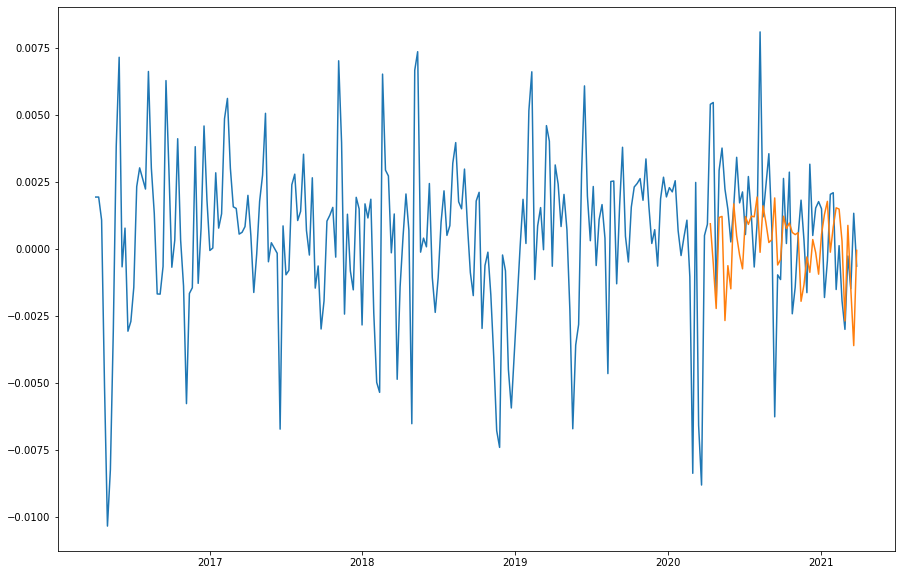

In [51]:
plt.figure(figsize=(15, 10))
plt.plot(df['CloseProc'])
idx = pd.date_range(df.index[-periods], periods=periods, freq='W')
plt.plot(pd.Series(fitted, index=idx))

In [52]:
import numpy as np

df['E'] = df['CloseProc'][:num]
df2 = pd.DataFrame()
df2['E'] = fitted
df.update(df2)
x, x_diff = boxcox(df['Close'], bx).iloc[0], df['E'].iloc[1:]
df['C'] = np.r_[x, x_diff].cumsum().astype(float)
df['X'] = inv_boxcox(df['C'], bx)
df

,Open,High,Low,Close,Adj Close,Volume,CloseProc,E,C,X,HW,HW2,HW3
Date,,,,,,,,,,,,,
2016-04-03,26.902000,27.215000,26.780999,27.070500,25.178509,118372000.0,0.001938,0.001938,1.436336,27.070500,0.001938,1.436336,27.070500
2016-04-10,27.451000,27.704500,27.259000,27.454500,25.535671,116578080.0,0.001938,0.001938,1.438275,27.454500,0.001938,1.438275,27.454500
2016-04-17,27.642000,27.907000,27.467501,27.672500,25.738435,129848000.0,0.001081,0.001081,1.439356,27.672500,0.001081,1.439356,27.672500
2016-04-24,26.767500,26.922500,26.468500,26.658500,24.795308,151242400.0,-0.005149,-0.005149,1.434207,26.658500,-0.005149,1.434207,26.658500
2016-05-01,24.825500,25.113000,24.543000,24.791000,23.058328,279539280.0,-0.010354,-0.010354,1.423853,24.791000,-0.010354,1.423853,24.791000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,124.795999,126.659999,121.592000,123.892000,123.892000,137149760.0,-0.003004,-0.002692,1.538226,71.654568,-0.000460,1.562913,102.268702
2021-03-07,123.940001,125.580000,121.166000,123.303999,123.303999,132261940.0,-0.000264,0.000880,1.539106,72.480308,0.000900,1.563813,103.764672
2021-03-14,120.918001,121.921999,118.974001,120.084000,120.084000,117111120.0,-0.001484,-0.001483,1.537623,71.097443,0.000165,1.563978,104.042076


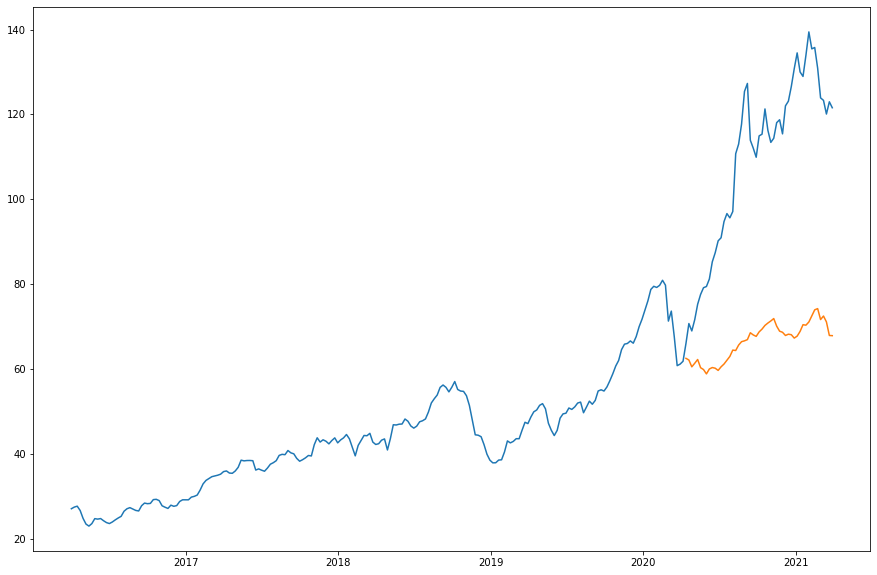

In [53]:
plt.figure(figsize=(15, 10))
plt.plot(df['Close'])
idx = pd.date_range(df.index[-periods], periods=periods, freq='W')
plt.plot(pd.Series(df['X'][num:], index=idx))

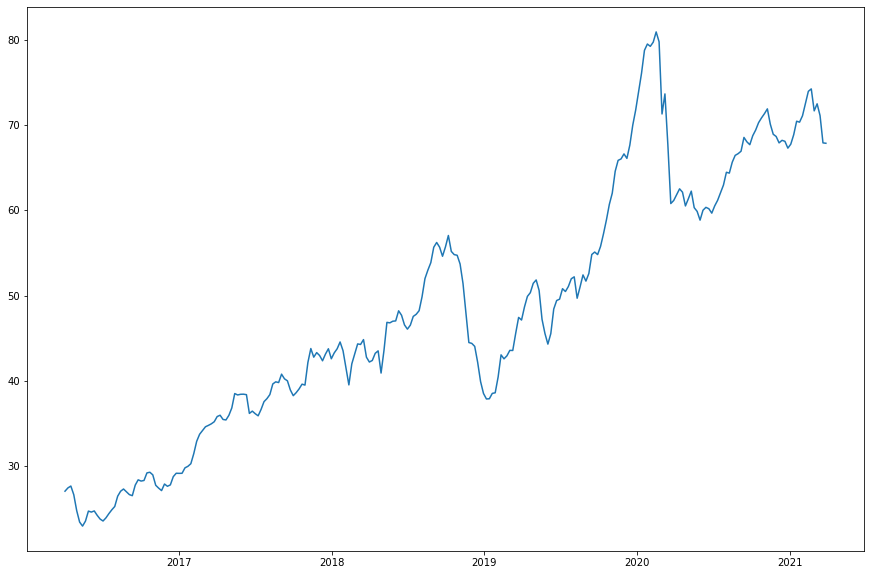

In [54]:
plt.figure(figsize=(15, 10))
plt.plot(df['X'])

In [55]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(df['Close'][-periods:], df['X'][-periods:])

0.37156244901638785

# Holter Winter

In [56]:
def HolterWinter(data, L, alpha, beta, gamma, m):
    # находим изначальные сезонности
    season_num = int(len(data)/L)# кол-во cезонов
    seasonalities = {} # сами сезонности
    season_avgs = [] # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L*i: L*i+L])/float(L) for i in range(season_num)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L*j+i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сгалженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    smooth = []
    season = []
    trend = []
    # пройдемся по всем данным + длинна предсказания m
    for i in range(len(data) + m):
        # инициализируем значения шага 0
        if i==0:
            smooth_val = data[0] # первое значения сглаживания
            trend_val = sum([float(data[j+L] - data[j]) / L for j in range(L)]) / L # первое значения тренда
            result.append(data[0]) # первая точка данных совпадает с исходной
            smooth.append(smooth_val) # добавляем первое значение сглаживание в массив трендов
            trend.append(trend_val) # добавляем первое значение тренда в массив трендов
            season.append(seasonalities[i%L]) # см mod L
            continue # завершаем первый шаг
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m*trend_val) + seasonalities[i%L])
        else: # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha*(data[i] - seasonalities[i%L]) + (1 - alpha)*(smooth_val + trend_val) # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val*(1 - beta) # обновляем bx
            seasonalities[i%L] = gamma * (data[i] - smooth_val) + (1 - gamma)*seasonalities[i%L] # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i%L]) # записываем результат

            smooth.append(smooth_val)
            trend.append(trend_val)
            season.append(seasonalities[i%L])
    return result[-m:]

In [57]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def predict(data, alpha, beta, gamma, m):
    return HolterWinter(data, L = 52, alpha=alpha, beta=beta, gamma=gamma, m=m)

def foo(x):
    alpha, beta, gamma = x
    tmp = predict(data = df['CloseProc'][:num].values, alpha=alpha, beta=beta, gamma=gamma, m = periods)
    return mean_squared_error(tmp, df['CloseProc'][num:].values)

In [58]:
# Минимизируем функцию потерь с ограничениями на параметры
optimizer = minimize(foo, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha, beta, gamma = optimizer.x
print(alpha, beta, gamma)

0.0 0.0 0.0


In [59]:
predicted = predict(df['CloseProc'][:num].values, alpha=alpha, beta=beta, gamma=gamma, m = periods)

df['HW'] = df['CloseProc'][:num]
df2 = pd.DataFrame()
df2['HW'] = predicted
df2['Date'] = df[num:].index
df2 = df2.set_index(['Date'])
df.update(df2)
x, x_diff = boxcox(df['Close'], bx).iloc[0], df['HW'].iloc[1:]
df['HW2'] = np.r_[x, x_diff].cumsum().astype(float)
df['HW3'] = inv_boxcox(df['HW2'], bx)
df

,Open,High,Low,Close,Adj Close,Volume,CloseProc,E,C,X,HW,HW2,HW3
Date,,,,,,,,,,,,,
2016-04-03,26.902000,27.215000,26.780999,27.070500,25.178509,118372000.0,0.001938,0.001938,1.436336,27.070500,0.001938,1.436336,27.070500
2016-04-10,27.451000,27.704500,27.259000,27.454500,25.535671,116578080.0,0.001938,0.001938,1.438275,27.454500,0.001938,1.438275,27.454500
2016-04-17,27.642000,27.907000,27.467501,27.672500,25.738435,129848000.0,0.001081,0.001081,1.439356,27.672500,0.001081,1.439356,27.672500
2016-04-24,26.767500,26.922500,26.468500,26.658500,24.795308,151242400.0,-0.005149,-0.005149,1.434207,26.658500,-0.005149,1.434207,26.658500
2016-05-01,24.825500,25.113000,24.543000,24.791000,23.058328,279539280.0,-0.010354,-0.010354,1.423853,24.791000,-0.010354,1.423853,24.791000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,124.795999,126.659999,121.592000,123.892000,123.892000,137149760.0,-0.003004,-0.002692,1.538226,71.654568,-0.000460,1.562913,102.268702
2021-03-07,123.940001,125.580000,121.166000,123.303999,123.303999,132261940.0,-0.000264,0.000880,1.539106,72.480308,0.000900,1.563813,103.764672
2021-03-14,120.918001,121.921999,118.974001,120.084000,120.084000,117111120.0,-0.001484,-0.001483,1.537623,71.097443,0.000165,1.563978,104.042076


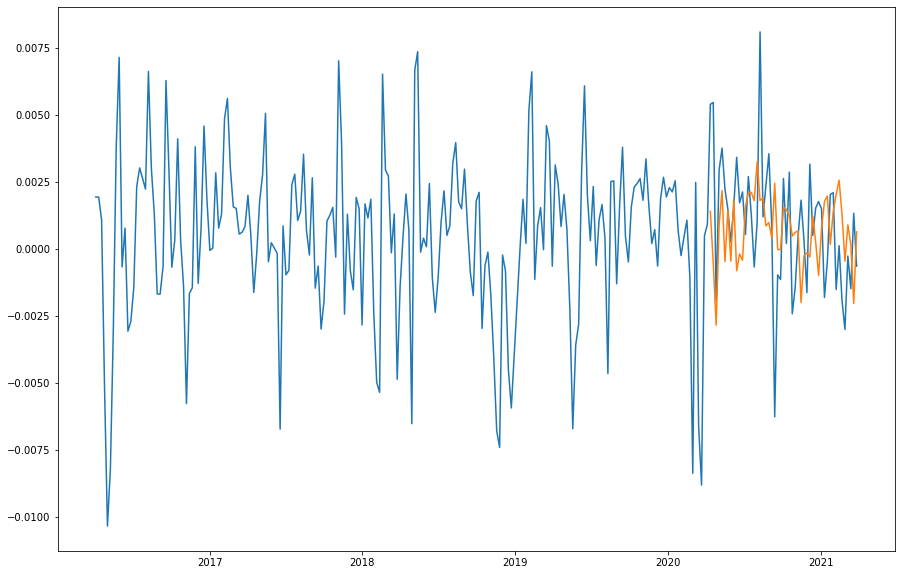

In [60]:
plt.figure(figsize=(15, 10))
plt.plot(df['CloseProc'])
idx = pd.date_range(df.index[-periods], periods=periods, freq='W')
plt.plot(pd.Series(df['HW'][num:], index=idx))

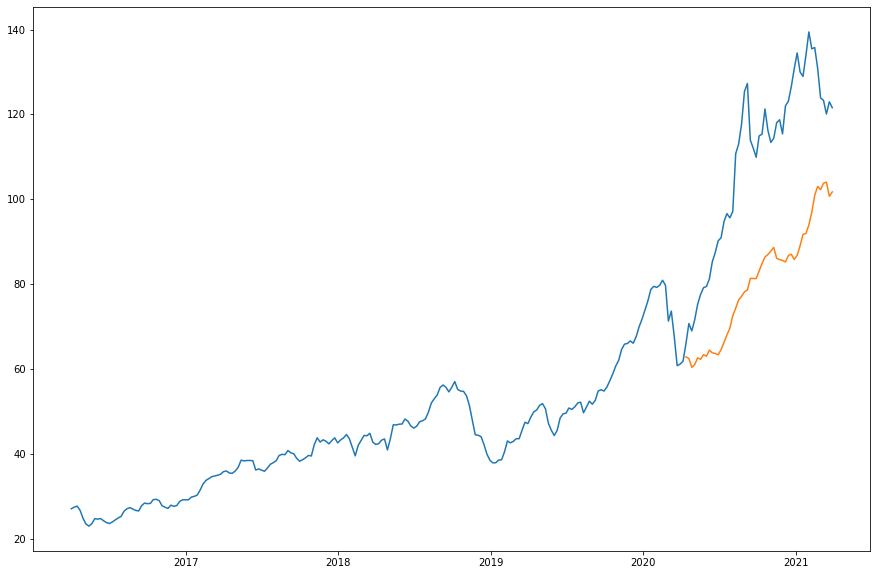

In [61]:
plt.figure(figsize=(15, 10))
plt.plot(df['Close'])
idx = pd.date_range(df.index[-periods], periods=periods, freq='W')
plt.plot(pd.Series(df['HW3'][num:], index=idx))

<AxesSubplot:xlabel='Date'>

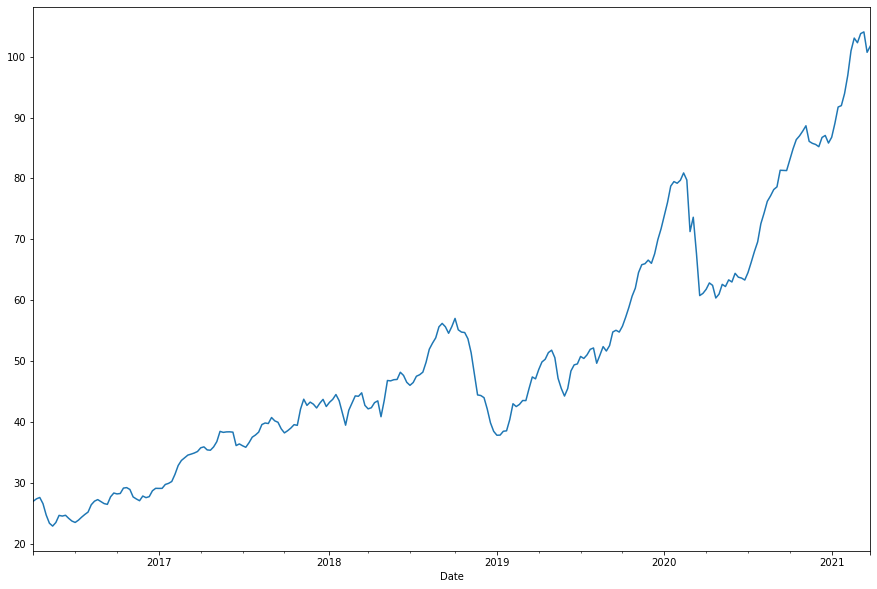

In [62]:
df['HW3'].plot(figsize=(15,10))

In [63]:
mean_absolute_percentage_error(df['Close'][-periods:], df['HW3'][-periods:])

0.25447091717809345